In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

In [2]:
trainDir = 'train/'
samples, sample_rate = librosa.load(trainDir+'bed/00176480_nohash_0.wav', sr = 16000)
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [3]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [4]:
labels=os.listdir(trainDir)

In [5]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

In [6]:
labels=["bed", "bird", "cat", "dog", "down", "eight", "five", "four"]

(array([2.0000e+00, 6.0000e+00, 4.2000e+01, 2.6000e+01, 9.0000e+01,
        1.5600e+02, 2.3300e+02, 1.9800e+02, 3.4800e+02, 1.3522e+04]),
 array([0.384 , 0.4456, 0.5072, 0.5688, 0.6304, 0.692 , 0.7536, 0.8152,
        0.8768, 0.9384, 1.    ]),
 <a list of 10 Patch objects>)

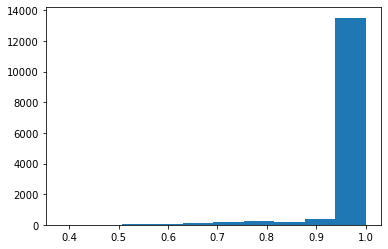

In [7]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(trainDir + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [8]:
trainDir = 'train/'
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(trainDir + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog
down
eight
five
four


In [66]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four']


In [42]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [43]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [44]:

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [45]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [46]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('voiceRecModel.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
print(x_tr.shape, x_val.shape, y_tr.shape, y_val.shape)

(10448, 8000, 1) (2613, 8000, 1) (10448, 8) (2613, 8)


In [48]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))


Epoch 1/100
327/327 [==============================] - 81s 249ms/step - loss: 1.8418 - accuracy: 0.2798 - val_loss: 1.5767 - val_accuracy: 0.3980
Epoch 2/100
327/327 [==============================] - 80s 245ms/step - loss: 1.5005 - accuracy: 0.4314 - val_loss: 1.3955 - val_accuracy: 0.4895
Epoch 3/100
327/327 [==============================] - 80s 245ms/step - loss: 1.2266 - accuracy: 0.5492 - val_loss: 0.9479 - val_accuracy: 0.6778
Epoch 4/100
327/327 [==============================] - 82s 252ms/step - loss: 0.9542 - accuracy: 0.6667 - val_loss: 1.0126 - val_accuracy: 0.6640
Epoch 5/100
327/327 [==============================] - 81s 249ms/step - loss: 0.7959 - accuracy: 0.7228 - val_loss: 0.7123 - val_accuracy: 0.7608
Epoch 6/100
327/327 [==============================] - 82s 249ms/step - loss: 0.7009 - accuracy: 0.7638 - val_loss: 0.5698 - val_accuracy: 0.8098
Epoch 7/100
327/327 [==============================] - 81s 247ms/step - loss: 0.5825 - accuracy: 0.8047 - val_loss: 0.6855 -

327/327 [==============================] - 82s 250ms/step - loss: 0.2039 - accuracy: 0.9302 - val_loss: 0.3794 - val_accuracy: 0.8879
Epoch 28/100
327/327 [==============================] - 81s 247ms/step - loss: 0.2028 - accuracy: 0.9334 - val_loss: 0.3591 - val_accuracy: 0.8928
Epoch 29/100
327/327 [==============================] - 83s 255ms/step - loss: 0.2015 - accuracy: 0.9294 - val_loss: 0.3673 - val_accuracy: 0.8978
Epoch 30/100
327/327 [==============================] - 84s 257ms/step - loss: 0.1980 - accuracy: 0.9305 - val_loss: 0.4304 - val_accuracy: 0.8806
Epoch 31/100
327/327 [==============================] - 80s 246ms/step - loss: 0.1890 - accuracy: 0.9366 - val_loss: 0.3204 - val_accuracy: 0.9028
Epoch 32/100
327/327 [==============================] - 83s 255ms/step - loss: 0.1726 - accuracy: 0.9408 - val_loss: 0.3295 - val_accuracy: 0.8982
Epoch 33/100
327/327 [==============================] - 90s 275ms/step - loss: 0.1925 - accuracy: 0.9359 - val_loss: 0.3274 - val_a

In [50]:
model.save("voiceRecModel.hdf5")

# Model Test

In [67]:
from keras.models import load_model

model = load_model("voiceRecModel.hdf5")

In [75]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)



Audio: five


In [76]:
print("Text:",predict(samples))

Text: five
